# Label CD4 T cell types

In this notebook, we'll retrieve the CD4 T cell Seurat object, label using the Azimuth cell type reference to guide labeling, then integrate and use ADT and Gene markers to label CD4 cell types.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
Seurat: single cell genomics methods

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(Seurat)

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the Seurat object based on its UUID. This will be placed in the `cache/` subdirectory by default.

In [2]:
cd4_so_uuid <- list("7bdac6ef-e5e5-4150-b4f3-9c1a1e250334")

In [3]:
fres <- cacheFiles(cd4_so_uuid)

submitting request as query ID first...

retrieving files using fileIDS...



We'll also need the Azimuth reference for label transfer. We can retrieve these files from this Zenodo entry:  
https://zenodo.org/record/4546839

This Reference dataset is based on this paper from the Satija lab:  
https://pubmed.ncbi.nlm.nih.gov/34062119/

In [4]:
dir.create("reference")

Warning message in dir.create("reference"):
“'reference' already exists”


In [5]:
options(timeout = 100000)
download.file(
    "https://zenodo.org/record/4546839/files/ref.Rds?download=1",
    "reference/pbmc_reference.rds"
)

## Prepare reference

Since our data consists of only CD4 T cells, we'll remove the other cell types from the reference prior to performing label transfer

In [6]:
ref <- readRDS("reference/pbmc_reference.rds")

In [7]:
table(ref$celltype.l1)


      B   CD4 T   CD8 T      DC    Mono      NK   other other T 
   2698   17646    5858     922    4564    2051    1078    1616 

In [8]:
ref <- ref[,ref$celltype.l1 == "CD4 T"]

In [9]:
ref

An object of class Seurat 
5228 features across 17646 samples within 2 assays 
Active assay: refAssay (5000 features, 0 variable features)
 1 other assay present: ADT
 2 dimensional reductions calculated: refUMAP, refDR

## Prepare dataset

The reference uses SCTransformed data. To enable label transfer, we'll run `SCTransform()` from the Seurat package to transform our data. We only need to do this on the set of features that are present in the reference.

We can also regress treatment and timepoint as we're most interested in cell type for label transfer, not the variation generated by treatment conditions.

In [10]:
so <- readRDS("cache/7bdac6ef-e5e5-4150-b4f3-9c1a1e250334/filtered_cd4_te_seurat.rds")

In [11]:
so <- SCTransform(
    so,
    residual.features = rownames(ref),
    vars.to.regress = c("treatment", "timepoint")
)

Computing residuals for the 5000 specified features

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 28744 by 114546

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 33 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Calculating gene attributes

Wall clock passed: Time difference of 1.847467 mins

Determine variable features

Setting min_variance to:  -Inf

Calculating residuals of type pearson for 4815 genes



  |======================================================================| 100%


Regressing out treatment, timepoint

Centering data matrix

Set default assay to SCT



In [12]:
length(VariableFeatures(so))

[1] 4815

## Transfer Labels

With the transformed data, we'll run anchor-based integration.

In [13]:
anchors <- FindTransferAnchors(
    reference = ref,
    query = so,
    features = VariableFeatures(so),
    normalization.method = "SCT",
    reference.reduction = "refDR",
    dims = 1:50,
    recompute.residuals = FALSE,
    verbose = FALSE
)

In [14]:
so <- suppressWarnings(
    MapQuery(
      anchorset = anchors,
      query = so,
      reference = ref,
      refdata = list(
        celltype.l1   = "celltype.l1",
        celltype.l2 = "celltype.l2",
        celltype.l3  = "celltype.l3"
      ),
      verbose = FALSE
    )
)

## Dimensionality reduction and visualization

To visualize results, we'll perform PCA and UMAP

In [15]:
so <- RunPCA(so, verbose = FALSE)

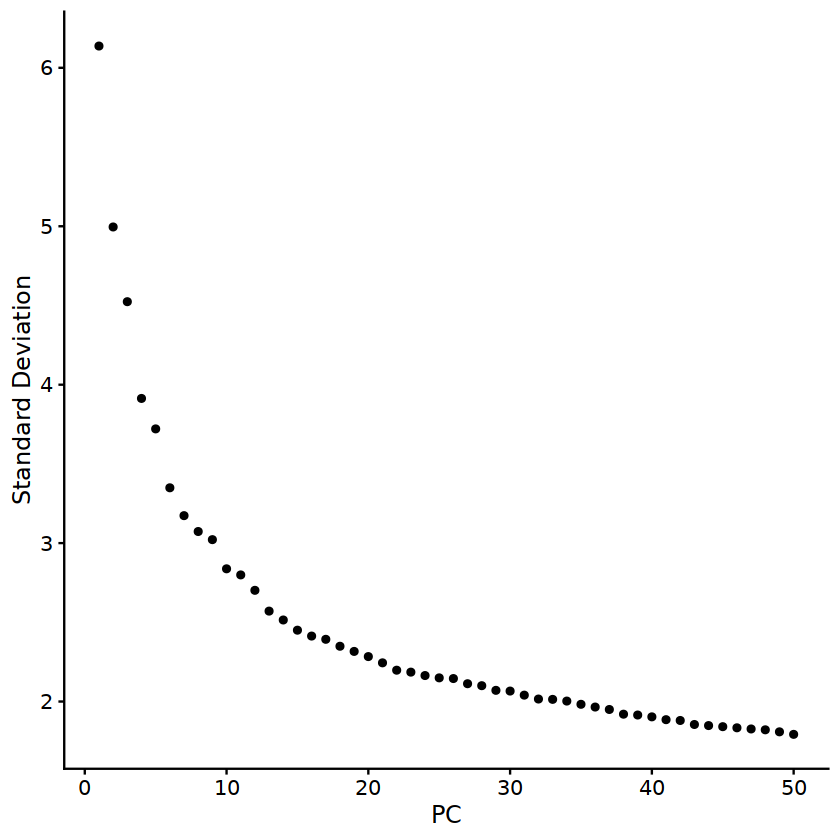

In [16]:
ElbowPlot(so, ndims = 50)

In [17]:
so <- RunUMAP(so, dims = 1:50, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


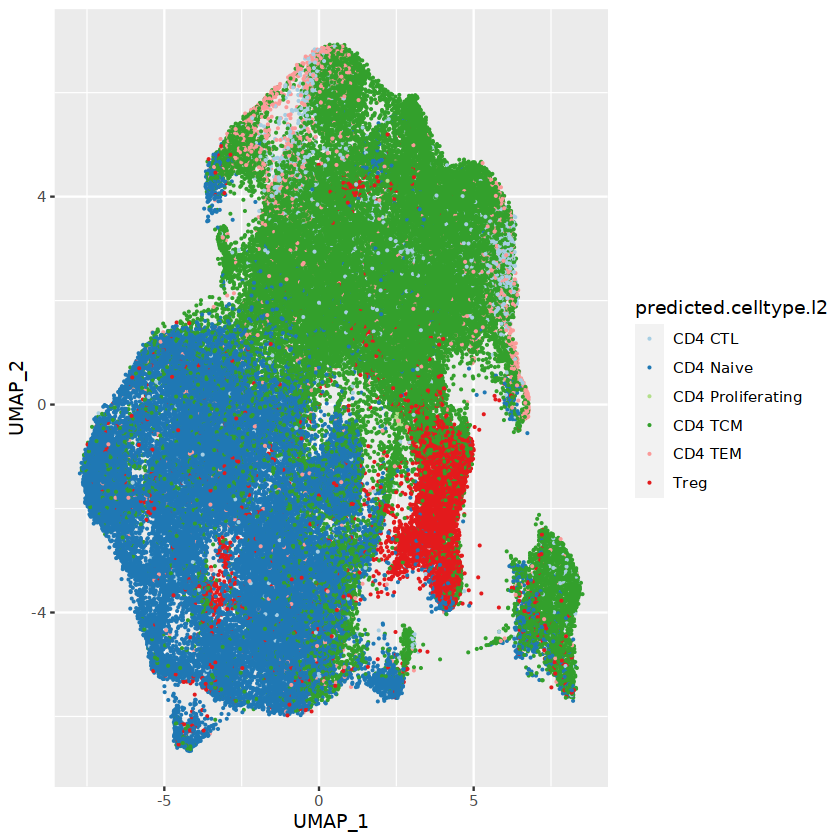

In [18]:
umap_df <- as.data.frame(so@reductions$umap@cell.embeddings)
umap_df <- cbind(so@meta.data, umap_df)

ggplot() +
  geom_point(
      data = umap_df,
      aes(x = UMAP_1,
          y = UMAP_2,
          color = predicted.celltype.l2),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

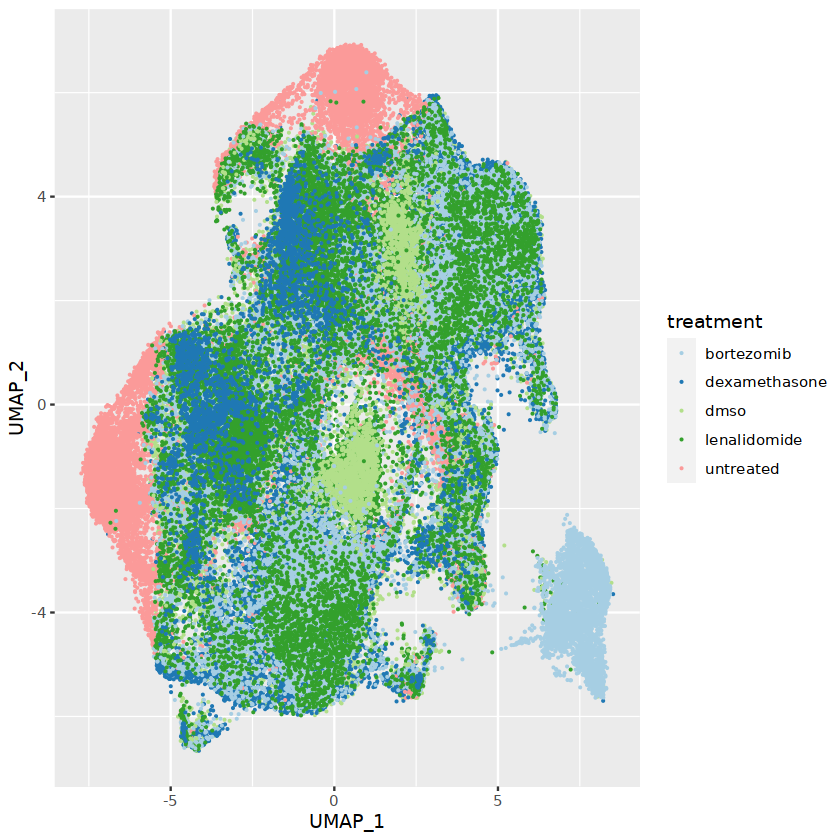

In [19]:
ggplot() +
  geom_point(
      data = umap_df,
      aes(x = UMAP_1,
          y = UMAP_2,
          color = treatment),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

## Integration, clustering, and marker-based labeling

The label transfer appears to work broadly, but there's a lot of mixing of cells in the reduced dimensionality space. This could be due the treatment conditions causing gene variability that is unrelated to cell type. It appears that regression in `SCTransform()` above was not able to remove this variability.

Below, we'll try a related approach - integrating samples within the dataset on Log Normalized data - to get cleaner grouping of cells based on cell type rather than treatment.

### Split all treat-times

In [20]:
full_so <- readRDS("cache/7bdac6ef-e5e5-4150-b4f3-9c1a1e250334/filtered_cd4_te_seurat.rds")

In [21]:
full_so$treat_time <- paste0(full_so$treatment, "_", full_so$timepoint)

In [22]:
table(full_so$treat_time)


   bortezomib_24     bortezomib_4    bortezomib_72 dexamethasone_24 
           13476            11503             3903             3331 
 dexamethasone_4          dmso_24           dmso_4          dmso_72 
           21209            17395             8485             2306 
 lenalidomide_24   lenalidomide_4  lenalidomide_72      untreated_0 
            8885             4422             5539            14092 

For integration and labeling, we'll use a subset of 2000 cells from each sample, then use those cells to label the full set of cells from each condition.

In [23]:
sample_cells <- 2000

In [24]:
split_so <- map(
    unique(full_so$treat_time),
    function(tt) {
        set.seed(3030)
        
        sel_so <- full_so[,full_so$treat_time == tt]
        sel_so[,sample(1:ncol(sel_so), sample_cells)]
    }
)

In [25]:
map_int(split_so, ncol)

[1] 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000

### Normalize and integrate data across samples

In [26]:
split_so <- map(
    split_so,
    function(so) {
        DefaultAssay(so) <- "RNA"
        so
    })

In [27]:
split_so <- map(
    split_so,
    function(so) {
        so <- NormalizeData(so)
        so <- FindVariableFeatures(so, nfeatures = 5000)
        so
    })

In [28]:
length(split_so)

[1] 12

In [29]:
split_anchors <- FindIntegrationAnchors(
    object.list = split_so, 
    dims = 1:30,
    verbose = FALSE
)

In [30]:
integ_so <- IntegrateData(
    anchorset = split_anchors, 
    dims = 1:30,
    verbose = FALSE
)

In [31]:
DefaultAssay(integ_so) <- "integrated"

In [32]:
integ_so <- ScaleData(integ_so)
integ_so <- RunPCA(integ_so, verbose = FALSE)

Centering and scaling data matrix



In [33]:
integ_so <- RunUMAP(integ_so, dims = 1:30, verbose = FALSE)

Let's add labels from the label transfer, above.

In [34]:
pred_labels <- so@meta.data %>%
  select(barcodes, predicted.celltype.l2)
integ_meta <- integ_so@meta.data
integ_meta <- integ_meta %>%
  left_join(pred_labels)
rownames(integ_meta) <- integ_meta$barcodes
integ_so@meta.data <- integ_meta

Joining with `by = join_by(barcodes)`


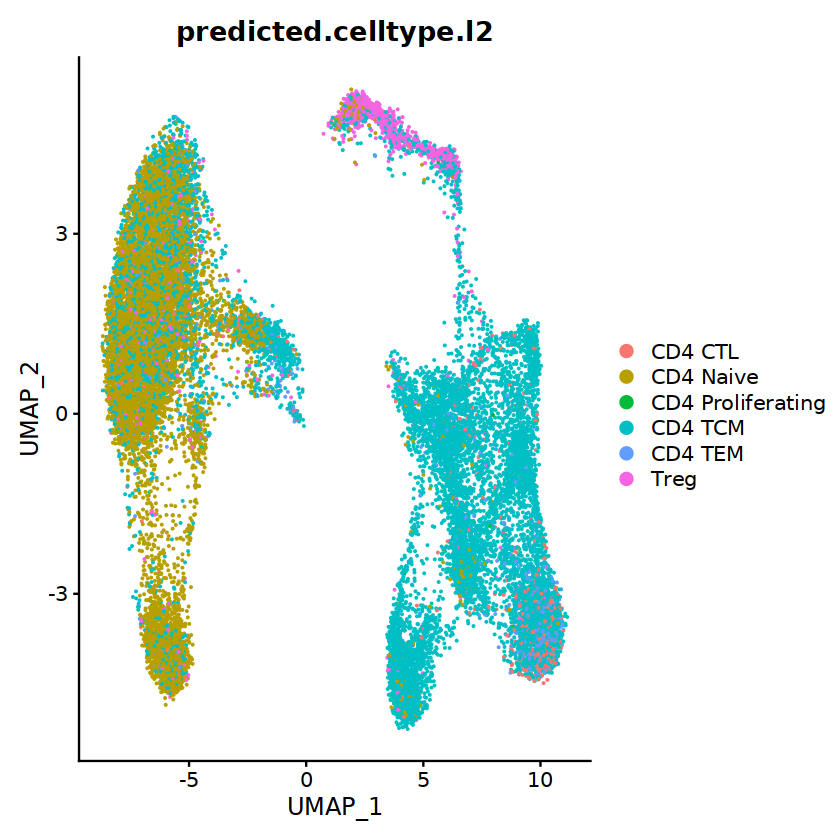

In [35]:
DimPlot(integ_so, group.by = "predicted.celltype.l2")

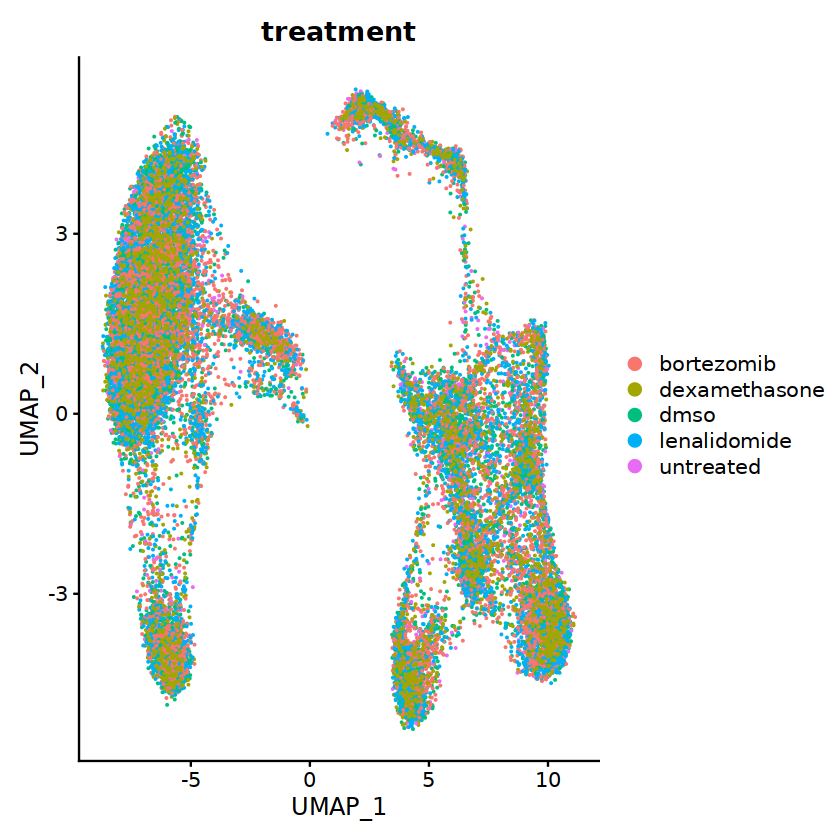

In [36]:
DimPlot(integ_so, group.by = "treatment")

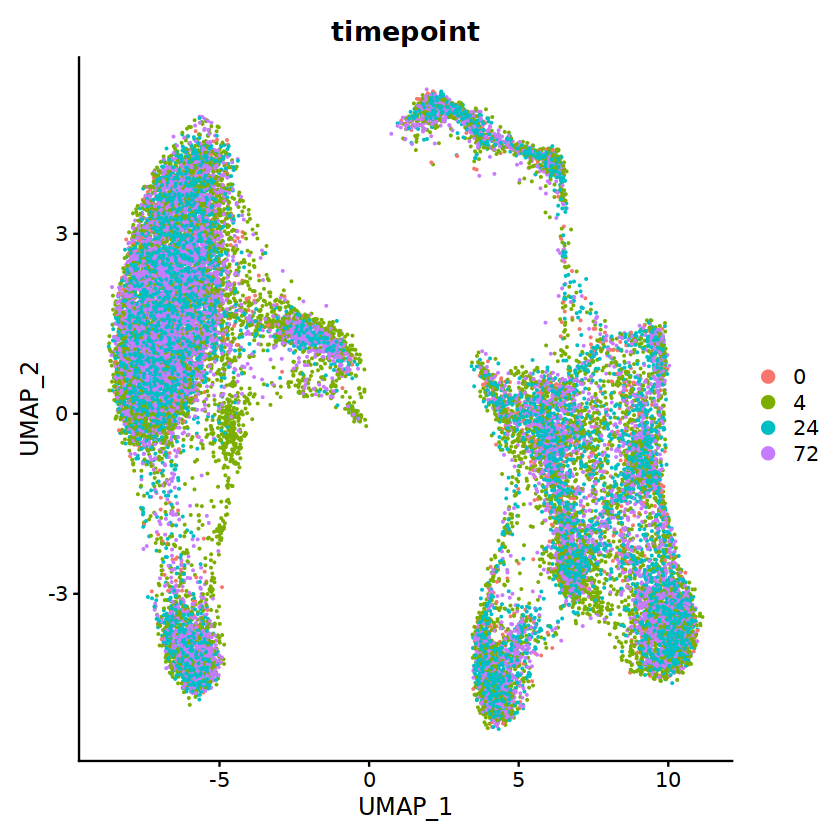

In [37]:
DimPlot(integ_so, group.by = "timepoint")

### Cluster and assign types

Next, we'll cluster the cells and then plot markers to assign T cell types.

In [38]:
integ_so <- FindNeighbors(integ_so, dims = 1:30, verbose = FALSE)
integ_so <- FindClusters(integ_so, verbose = FALSE)

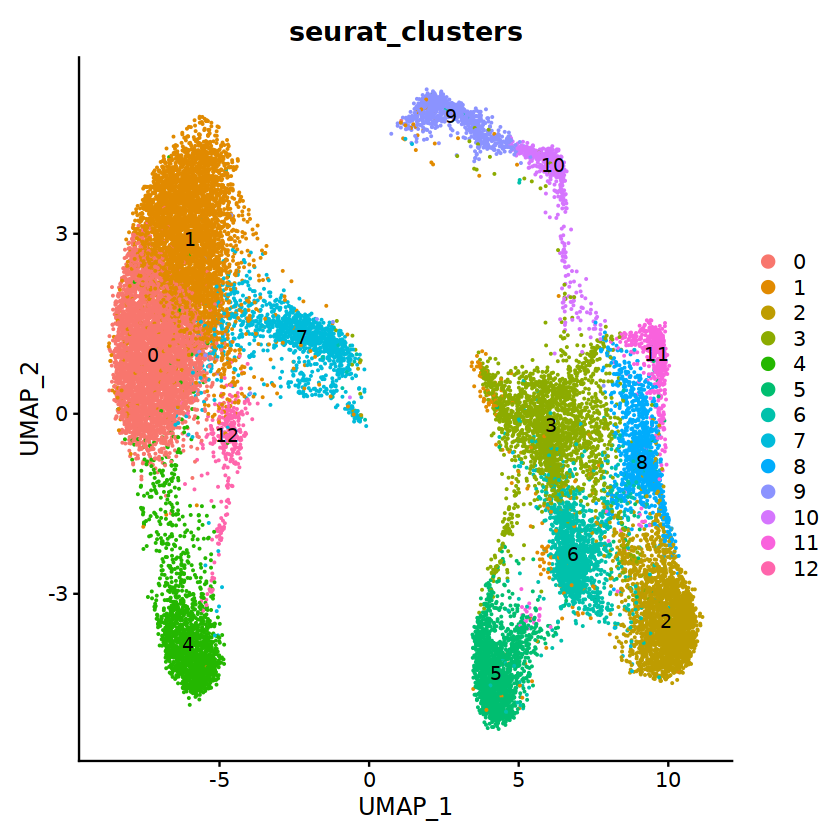

In [39]:
DimPlot(
    integ_so, 
    group.by = "seurat_clusters",
    label = TRUE
)

To plot ADT markers, we'll normalize counts using CLR.

In [40]:
DefaultAssay(integ_so) <- "ADT"
integ_so <- NormalizeData(
    integ_so, 
    normalization.method = "CLR",
    margin = 2
)

Normalizing across cells



In [41]:
rownames(integ_so)

[1] "CD11c"                   "CD278"                  
 [3] "CD11b"                   "CD16"                   
 [5] "CD21"                    "CD27"                   
 [7] "CD304"                   "CD38"                   
 [9] "CD71"                    "CD86"                   
[11] "HLA.DR"                  "TCR.Va7.2"              
[13] "CD127"                   "CD39"                   
[15] "CD25"                    "CD4"                    
[17] "CD56"                    "CD161"                  
[19] "CD85j"                   "CX3CR1"                 
[21] "CD185"                   "CD152"                  
[23] "CD194"                   "CD196"                  
[25] "CD244"                   "CD26"                   
[27] "CD49d"                   "CD294"                  
[29] "CD279"                   "CD8a"                   
[31] "CD103"                   "CD57"                   
[33] "CD69"                    "CD366"                  
[35] "CD172a"                  "CD192"                  
[37] "CD45RA"                  "CD95"                   
[39] "KLRG1"                   "CD137"                  
[41] "CD183"                   "CD80"                   
[43] "TCR.G.D"                 "CD40"                   
[45] "TCR.A.B"                 "CD197"                  
[47] "CD28"                    "CD45RO"                 
[49] "TIGIT"                   "CD134"                  
[51] "CD154"                   "TCR.VA24.JA18.iNKT.cell"
[53] "CD24"                    "CD319"                  
[55] "IgG1.K.Isotype.Control"

In [42]:
DefaultAssay(integ_so) <- "ADT"
markers <- FindMarkers(integ_so, ident.1 = "3", ident.2 = "0", logfc.threshold = 0)
markers %>%
  arrange(desc(avg_log2FC)) %>%
  head()

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
CD49d   0.000000e+00 0.4004003  1.000 1.000  0.000000e+00
CD95    0.000000e+00 0.3612652  1.000 1.000  0.000000e+00
CD161  1.370002e-149 0.2006792  0.962 0.915 7.535013e-148
CD69    9.095747e-24 0.1782333  0.999 0.996  5.002661e-22
CD278  1.088768e-139 0.1687113  0.996 0.988 5.988222e-138
CD45RO  0.000000e+00 0.1288856  1.000 1.000  0.000000e+00

In [43]:
DefaultAssay(integ_so) <- "RNA"
markers <- FindMarkers(integ_so, ident.1 = "3", ident.2 = "0", logfc.threshold = 0)
markers$diff <- markers$pct.1 - markers$pct.2
markers %>%
  arrange(desc(diff)) %>%
  head(10)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     diff 
ADAM19   0.000000e+00 2.167642   0.592 0.026  0.000000e+00 0.566
PHACTR2  0.000000e+00 1.926690   0.721 0.180  0.000000e+00 0.541
MAF      0.000000e+00 1.984229   0.528 0.022  0.000000e+00 0.506
TOX      0.000000e+00 2.500833   0.511 0.018  0.000000e+00 0.493
ATXN1    0.000000e+00 1.900874   0.887 0.395  0.000000e+00 0.492
ARAP2    0.000000e+00 2.109084   0.809 0.324  0.000000e+00 0.485
ITGB1    0.000000e+00 1.878589   0.625 0.165  0.000000e+00 0.460
NIBAN1   0.000000e+00 2.002460   0.480 0.058  0.000000e+00 0.422
ST8SIA1  0.000000e+00 1.873463   0.419 0.013  0.000000e+00 0.406
SAMSN1  2.028825e-277 1.376879   0.552 0.161 7.425701e-273 0.391

In [44]:
markers %>%
  arrange(diff) %>%
  head(10)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     diff  
IGF1R   0.000000e+00 -2.660050  0.152 0.867  0.000000e+00 -0.715
UBE2E2 6.589476e-294 -2.194844  0.022 0.466 2.411814e-289 -0.444
PLCL1  7.980131e-254 -1.555208  0.370 0.777 2.920808e-249 -0.407
BACH2   0.000000e+00 -1.310501  0.557 0.927  0.000000e+00 -0.370
MAN1C1 1.405758e-205 -1.294936  0.223 0.591 5.145215e-201 -0.368
DACT1  1.773709e-217 -1.360907  0.012 0.361 6.491951e-213 -0.349
PCSK5  3.575206e-203 -1.413724  0.046 0.394 1.308561e-198 -0.348
TXK    1.083629e-210 -1.152793  0.452 0.783 3.966191e-206 -0.331
PRKN   1.094975e-150 -1.227996  0.184 0.508 4.007718e-146 -0.324
CERS6  3.327412e-145 -1.060088  0.217 0.537 1.217866e-140 -0.320

In [45]:
type_markers <- c(
    "UBE2E2", # CD4 Naive 
    "MAF", # CD4 Memory
    "CCL5", # CD4 EM
    "FOXP3" # CD4 Treg
)

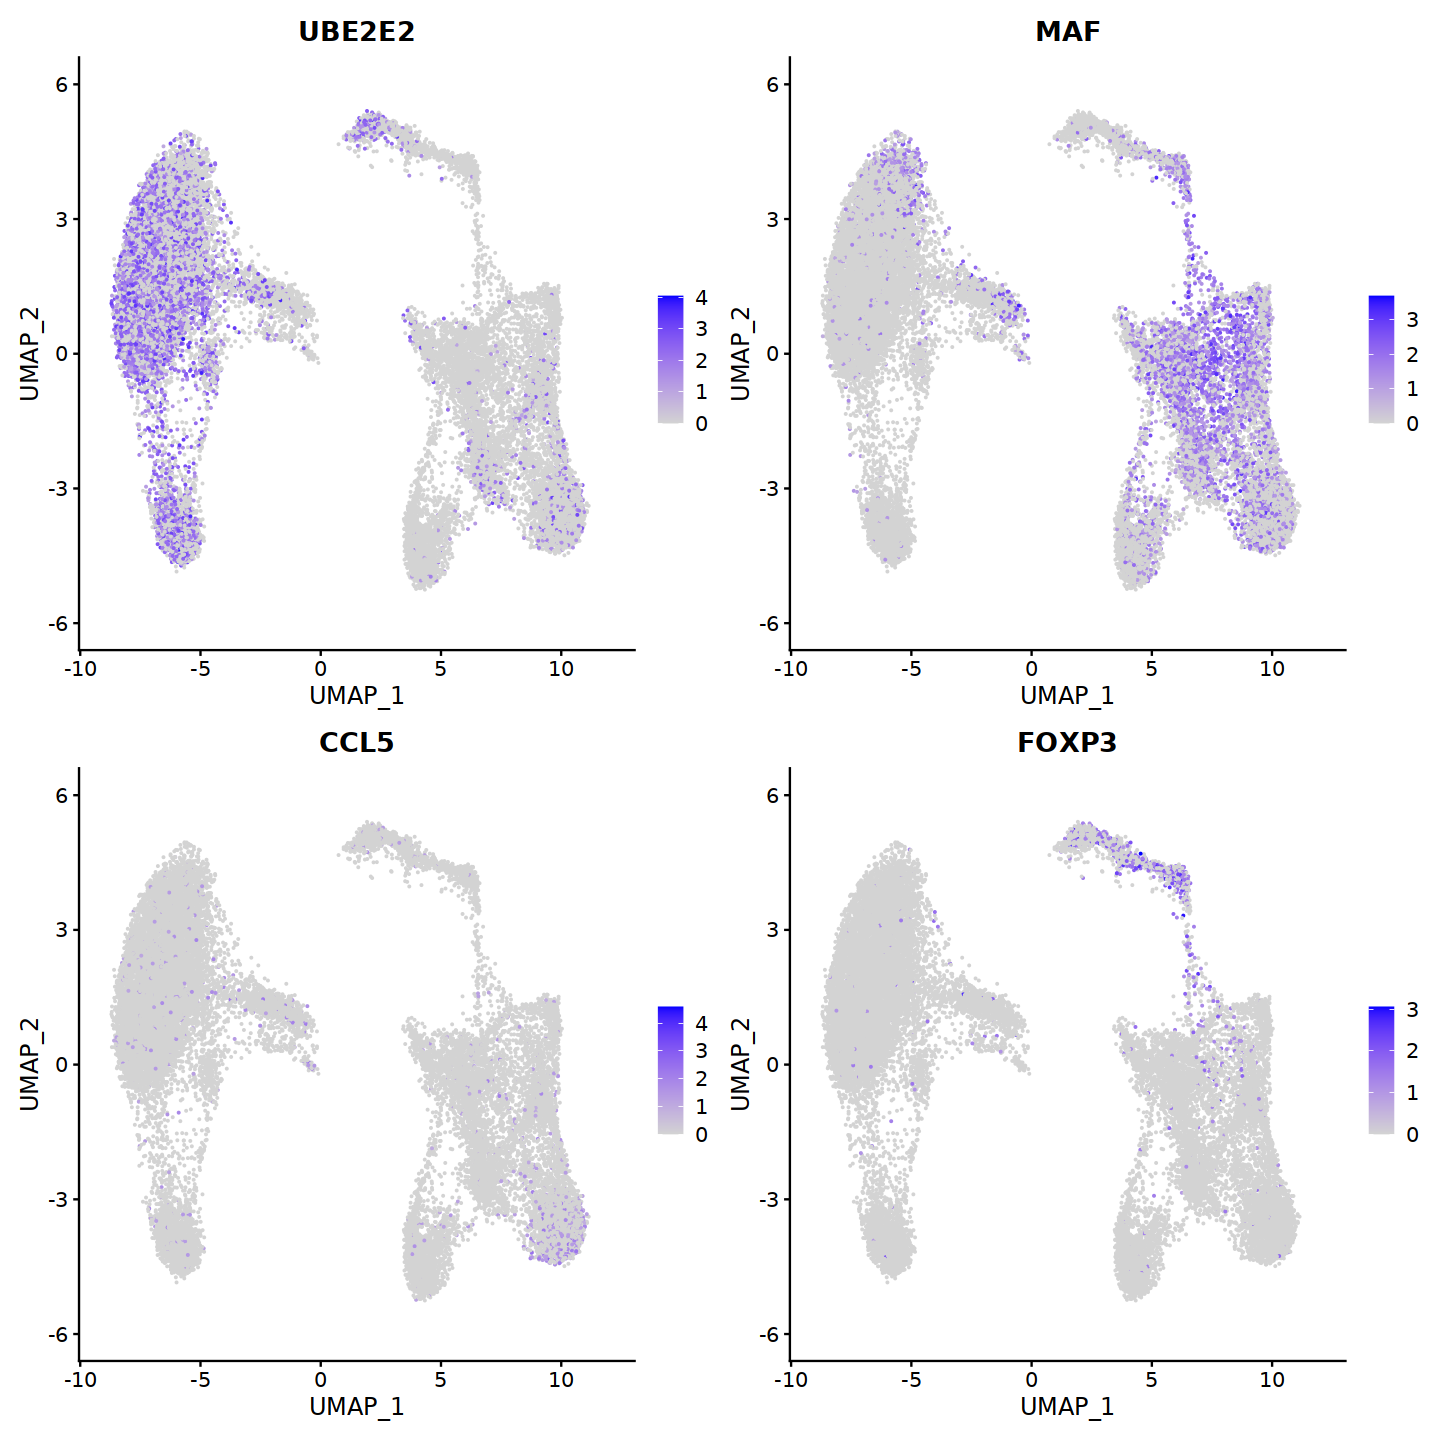

In [46]:
options(repr.plot.width = 12, repr.plot.height = 12)
FeaturePlot(integ_so, features = type_markers)

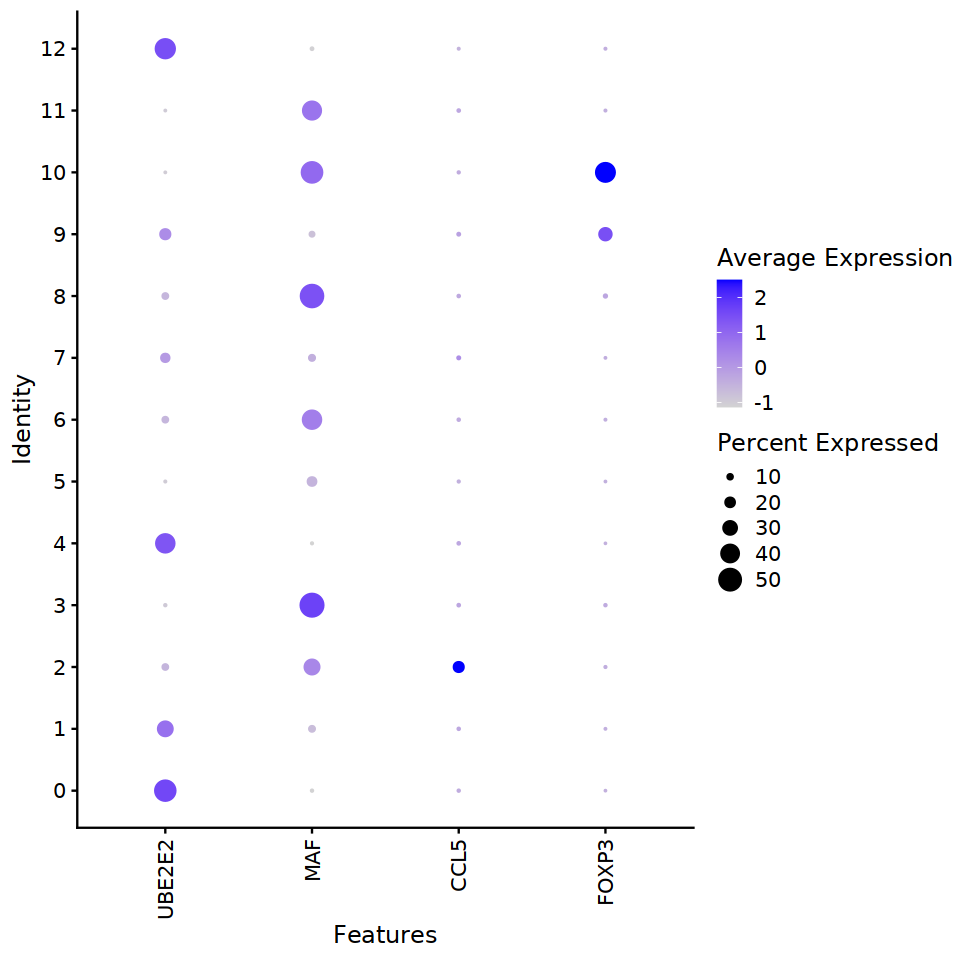

In [47]:
options(repr.plot.width = 8, repr.plot.height = 8)
DotPlot(
    integ_so,
    features = type_markers,
    group.by = "seurat_clusters"
)  +
  ggplot2::theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1, vjust = 0.5))

We'll apply these cutoffs to assign cell types

In [48]:
# Naive CD4:
ube2e2_cutoff <- 0.15
# CD4 CM:
maf_cutoff <- 0.15
# CD4 EM:
ccl5_cutoff <- 0.1
# CD4 Treg
foxp3_cutoff <- 0.1

In [49]:
marker_mat <- integ_so[["RNA"]]@counts[type_markers,]
clusters <- integ_so@meta.data$seurat_clusters

In [50]:
marker_fracs <- map(
    type_markers,
    function(marker) {
        cl_list <- split(marker_mat[marker,], clusters)
        cl_frac <- map_dbl(cl_list, function(x) { sum(x > 0) / length(x) })
        cl_frac
    })
names(marker_fracs) <- type_markers
marker_df <- data.frame(
    cl = names(marker_fracs[[1]]),
    do.call(cbind, marker_fracs)
)

In [51]:
head(marker_df)

cl UBE2E2     MAF        CCL5       FOXP3      
0 0  0.46554935 0.02234637 0.02317401 0.006621146
1 1  0.32736842 0.10800000 0.02568421 0.010105263
2 2  0.10433715 0.33101473 0.21031097 0.016775777
3 3  0.02195872 0.52832675 0.02942468 0.023715415
4 4  0.41585296 0.01665709 0.02814474 0.005169443
5 5  0.01415094 0.17688679 0.01886792 0.007665094

In [52]:
cl_types <- marker_df %>%
  mutate(
      aifi_cell_type = case_when(
          FOXP3 > foxp3_cutoff ~ "t_cd4_treg",
          CCL5 > ccl5_cutoff ~ "tc_cd4_em",
          MAF > maf_cutoff ~ "t_cd4_cm",
          UBE2E2 > ube2e2_cutoff ~ "t_cd4_naive"
      )
  )

In [53]:
cl_types

cl UBE2E2      MAF        CCL5       FOXP3       aifi_cell_type
0  0  0.465549348 0.02234637 0.02317401 0.006621146 t_cd4_naive   
1  1  0.327368421 0.10800000 0.02568421 0.010105263 t_cd4_naive   
2  2  0.104337152 0.33101473 0.21031097 0.016775777 tc_cd4_em     
3  3  0.021958718 0.52832675 0.02942468 0.023715415 t_cd4_cm      
4  4  0.415852958 0.01665709 0.02814474 0.005169443 t_cd4_naive   
5  5  0.014150943 0.17688679 0.01886792 0.007665094 t_cd4_cm      
6  6  0.104792332 0.41597444 0.02555911 0.012140575 t_cd4_cm      
7  7  0.168217054 0.11085271 0.03643411 0.008527132 t_cd4_naive   
8  8  0.105742935 0.51686418 0.02734731 0.044667274 t_cd4_cm      
9  9  0.211663067 0.08531317 0.03455724 0.267818575 t_cd4_treg    
10 10 0.009174312 0.46972477 0.02018349 0.427522936 t_cd4_treg    
11 11 0.009578544 0.40804598 0.02873563 0.013409962 t_cd4_cm      
12 12 0.436305732 0.03184713 0.01273885 0.012738854 t_cd4_naive

In [54]:
integ_so@meta.data$aifi_cell_type <- cl_types$aifi_cell_type[match(integ_so@meta.data$seurat_clusters, cl_types$cl)]

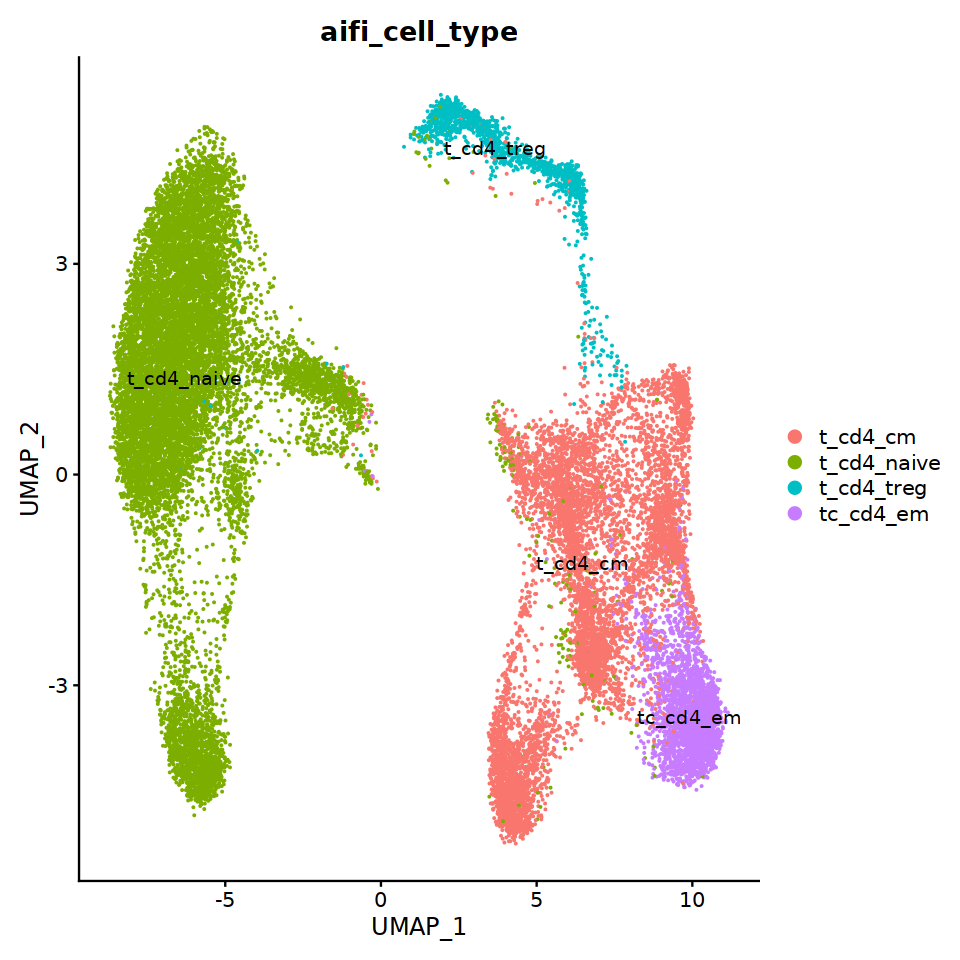

In [55]:
DimPlot(
    integ_so, 
    group.by = "aifi_cell_type",
    label = TRUE
)

### Apply labels to all cells by clustering within each sample

In [56]:
integ_labels <- integ_so@meta.data %>%
  select(barcodes, aifi_cell_type)

In [57]:
split_so <- map(
    unique(full_so$treat_time),
    function(tt) {
        set.seed(3030)
        
        sel_so <- full_so[,full_so$treat_time == tt]
        sel_meta <- sel_so@meta.data
        sel_meta <- sel_meta %>%
          left_join(integ_labels)
        rownames(sel_meta) <- sel_meta$barcodes
        sel_so@meta.data <- sel_meta
        sel_so
    }
)

Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`
Joining with `by = join_by(barcodes)`


In [58]:
split_so <- map(
    split_so,
    function(so) {
        message(paste("Processing", so@meta.data$treat_time[1]))
        so <- FindVariableFeatures(so)
        so <- NormalizeData(so)
        so <- ScaleData(so)
        so <- RunPCA(so, verbose = FALSE)
        so <- FindNeighbors(so, dims = 1:30, verbose = FALSE)
        so <- FindClusters(so, verbose = FALSE)
        so
    })

Processing dmso_24

Centering and scaling data matrix

Processing dmso_4

Centering and scaling data matrix

Processing dexamethasone_4

Centering and scaling data matrix

Processing untreated_0

Centering and scaling data matrix

Processing lenalidomide_72

Centering and scaling data matrix

Processing bortezomib_24

Centering and scaling data matrix

Processing bortezomib_4

Centering and scaling data matrix

Processing lenalidomide_24

Centering and scaling data matrix

Processing dmso_72

Centering and scaling data matrix

Processing lenalidomide_4

Centering and scaling data matrix

Processing bortezomib_72

Centering and scaling data matrix

Processing dexamethasone_24

Centering and scaling data matrix



A helper function for finding most frequent cell type values within each cluster

In [59]:
mfv <- function(x) {
    x <- x[!is.na(x)]
    t <- table(x)
    t <- t[order(t, decreasing = TRUE)]
    names(t)[1]
}

In [60]:
type_labels <- map_dfr(
    split_so,
    function(so) {
        message(paste("Processing", so@meta.data$treat_time[1]))

        meta <- so@meta.data
        meta %>%
          group_by(seurat_clusters) %>%
          mutate(aifi_cell_type = mfv(aifi_cell_type)) %>%
          ungroup() %>%
          select(barcodes, aifi_cell_type)
    })

Processing dmso_24

Processing dmso_4

Processing dexamethasone_4

Processing untreated_0

Processing lenalidomide_72

Processing bortezomib_24

Processing bortezomib_4

Processing lenalidomide_24

Processing dmso_72

Processing lenalidomide_4

Processing bortezomib_72

Processing dexamethasone_24



In [61]:
table(type_labels$aifi_cell_type)


   t_cd4_cm t_cd4_naive  t_cd4_treg   tc_cd4_em 
      35414       59897        7094       12141 

Let's transfer these to the full Seurat object and visualize these labels

In [62]:
so_meta <- so@meta.data
so_meta <- so_meta %>%
  left_join(type_labels)
rownames(so_meta) <- so_meta$barcodes
so@meta.data <- so_meta

Joining with `by = join_by(barcodes)`


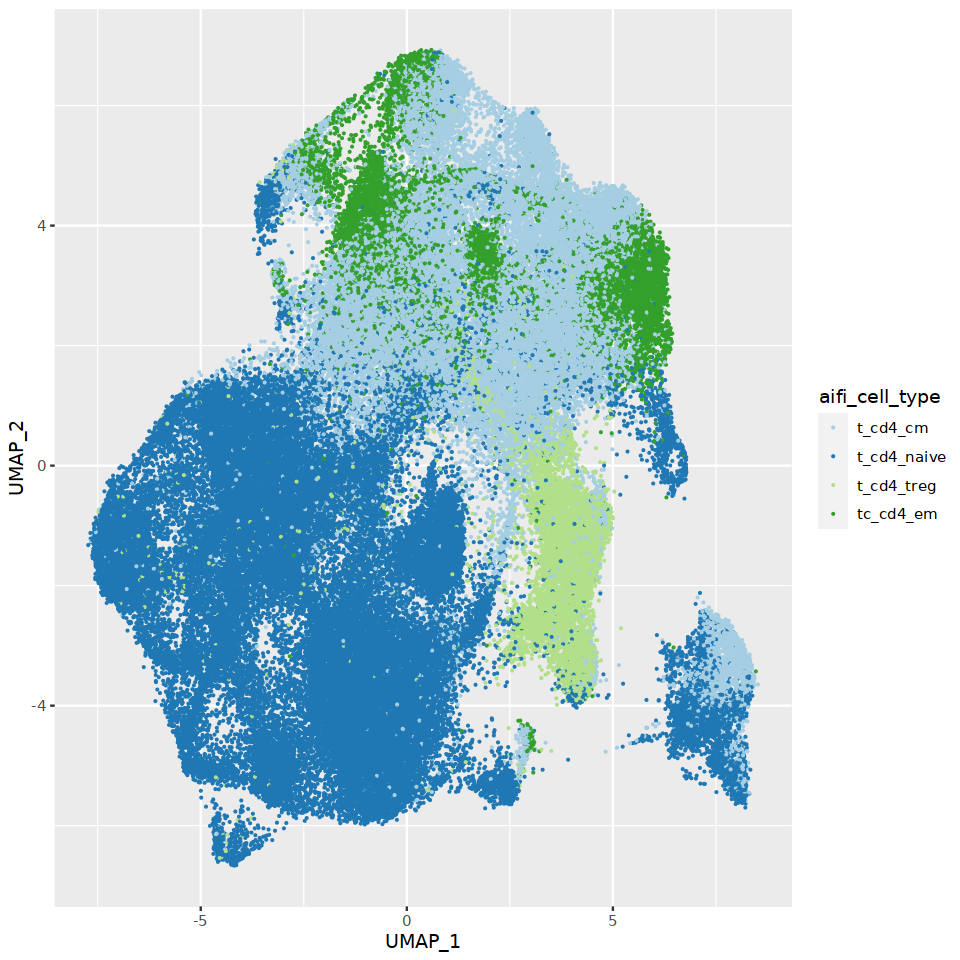

In [63]:
umap_df <- as.data.frame(so@reductions$umap@cell.embeddings)
umap_df <- cbind(so@meta.data, umap_df)

ggplot() +
  geom_point(
      data = umap_df,
      aes(x = UMAP_1,
          y = UMAP_2,
          color = aifi_cell_type),
      size = 0.1
  ) +
  scale_color_brewer(
      type = "qual",
      palette = 3
  )

## Generate output files

For downstream use, we'll output the table of aifi_cell_type labels for each cell.

In [64]:
dir.create("output")

Warning message in dir.create("output"):
“'output' already exists”


In [66]:
out_labels <- so_meta %>%
  select(barcodes, treatment, timepoint, starts_with("predicted"), aifi_cell_type)

In [67]:
write.csv(out_labels,
          "output/cd4_cell_type_labels.csv",
          quote = FALSE, row.names = FALSE)

## Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference. For this analysis, we used just one input file, defined in `cd4_so_uuid`.

In [68]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- "VRd TEA-seq CD4 Cell Type Labels"

In [69]:
out_files <- list.files(
    "output",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [70]:
out_list

[[1]]
[1] "output/cd4_cell_type_labels.csv"

In [71]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = cd4_so_uuid,
    store = "project",
    doPrompt = FALSE
)

[1] "Authorization token invalid or expired."
[1] "Retrying..."


$files
$files[[1]]
[1] "output/cd4_cell_type_labels.csv"


$traceId
[1] "8f4dfcdb-6751-4468-a24c-b24f2870b7ad"

In [72]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] SeuratObject_4.1.3 Seurat_4.3.0.1     ggplot2_3.4.3      dplyr_1.1.2       
[5] purrr_1.0.2        hise_2.16.0       

loaded via a namespace (and not attached):
  [1] bitops_1.0-7           deldir_1.0-9           pbapply_1.7-2         
  [4] gridExtra_2.3          rlang_1.1.1            magrittr_2.0.3      